# Data for datacenter

The data comes from the repository <https://github.com/shivangidas/impact/tree/master/data>

In [40]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

plt.style.use('tableau-colorblind10')

In [41]:
url ='https://raw.githubusercontent.com/shivangidas/impact/master/data/' # my fork
impacturl = 'impact.csv'

df = pd.read_csv(url+impacturl)
df.head()

,provider,providerName,offsetRatio,region,regionName,country,state,city,impact,source,comment
0,gcp,Google Cloud Platform,100,asia-east1,NaN,Taiwan,NaN,Changhua County,585.0,"measured on September 4, 2020 between 6 and 7...",NaN
1,gcp,Google Cloud Platform,100,asia-east2,NaN,China,NaN,Hong Kong,702.0,https://www.sciencedirect.com/science/article/...,NaN
2,gcp,Google Cloud Platform,100,asia-northeast1,NaN,Japan,NaN,Tokyo,516.0,https://www.sciencedirect.com/science/article/...,NaN
3,gcp,Google Cloud Platform,100,asia-northeast2,NaN,Japan,NaN,Osaka,516.0,https://www.fepc.or.jp/library/pamphlet/pdf/04...,NaN
4,gcp,Google Cloud Platform,100,asia-south1,NaN,India,NaN,Mumbai,708.0,https://www.carbonfootprint.com/docs/2020_07_e...,Climate Transparency (2019 Report)


In [42]:
df.nunique()

provider         3
providerName     3
offsetRatio      2
region          74
regionName      54
country         21
state           31
city            57
impact          30
source          10
comment          3
dtype: int64

In [43]:
# pd.set_option('display.max_colwidth',-1)
# df['source']

In [44]:
gpuurl = 'gpus.csv'
df_gpu= pd.read_csv(url+gpuurl)
df_gpu.head()

,name,type,watt,TFLOPS32,TFLOPS16,GFLOPS32/W,GFLOPS16/W,memory,source
0,RTX 2080 Ti,gpu,250,13.45,26.90,53.80,107.60,11.0,techpowerup.com
1,RTX 2080,gpu,215,10.00,20.00,46.51,93.02,8.0,techpowerup.com
2,GTX 1080 Ti,gpu,250,11.34,0.17,45.36,0.68,11.0,techpowerup.com
3,GTX 1080,gpu,180,8.00,0.13,44.44,0.72,8.0,techpowerup.com
4,AMD RX480,gpu,150,5.80,5.80,38.67,38.67,8.0,techpowerup.com


In [45]:
print(df_gpu.nunique())

name          17
type           3
watt          10
TFLOPS32      17
 TFLOPS16     13
GFLOPS32/W    17
GFLOPS16/W    13
memory         7
source         5
dtype: int64


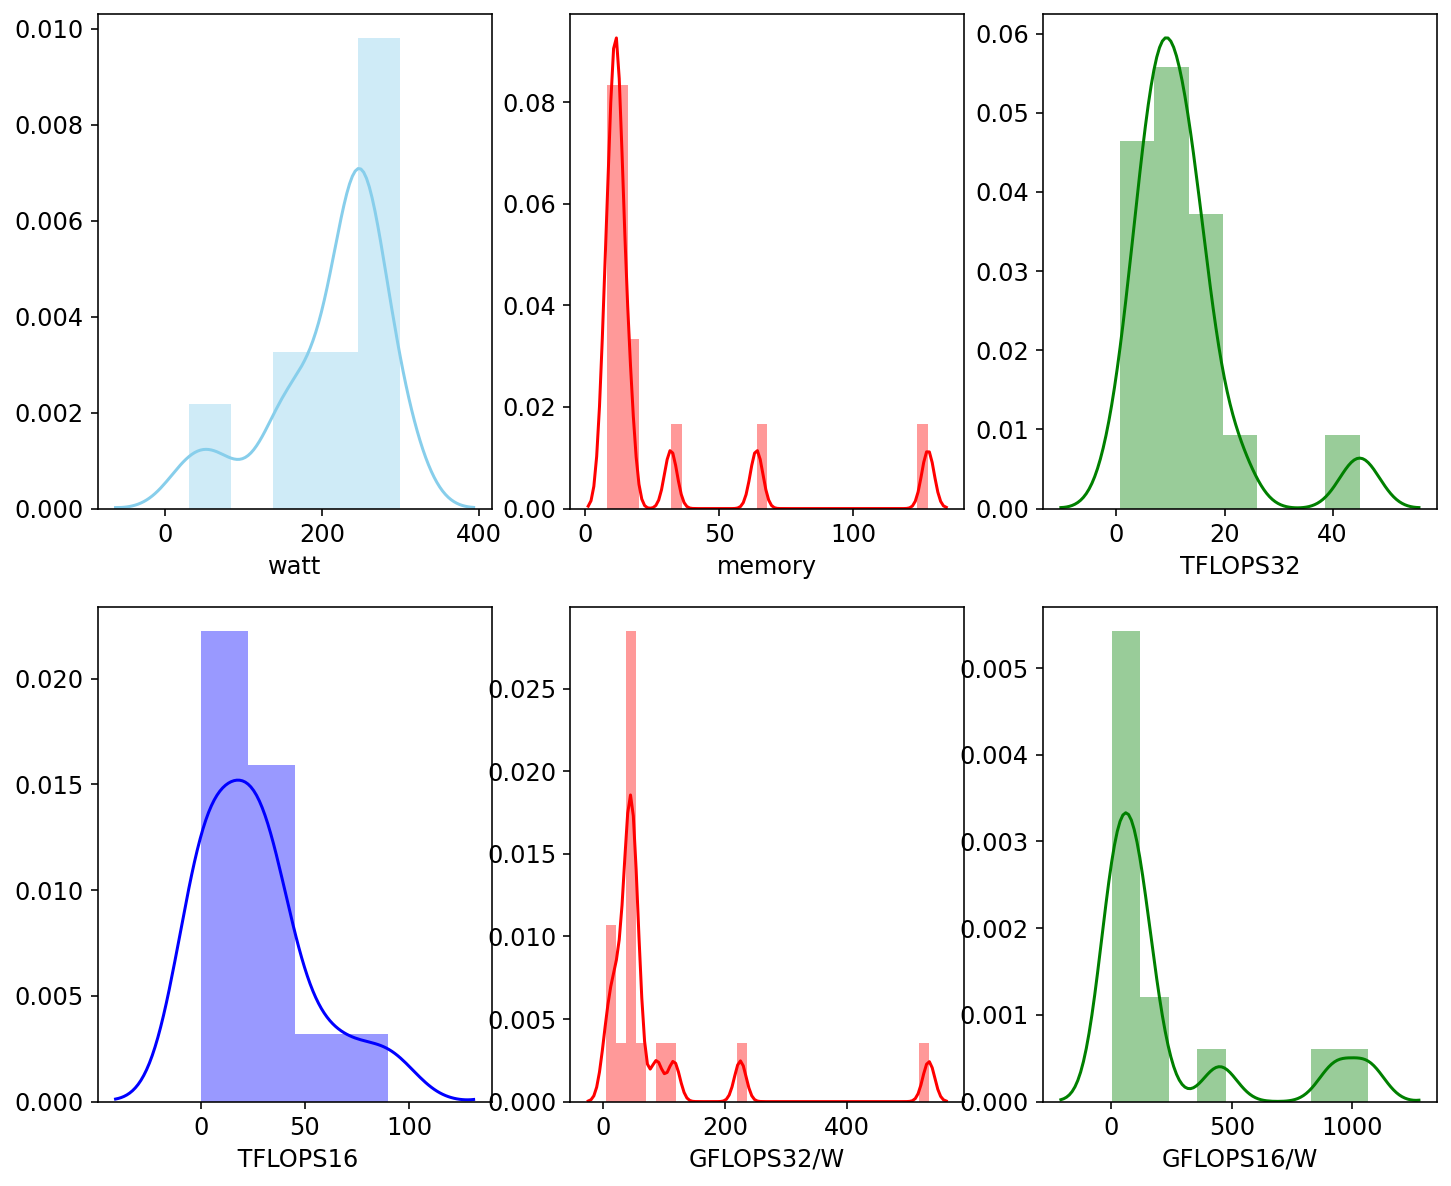

In [46]:
f, axes = plt.subplots(2, 3, figsize=(12,10))
sns.distplot(df_gpu['watt'],color='skyblue',label='watt', ax=axes[0, 0])
sns.distplot(df_gpu['memory'],color='red',label='memory', ax=axes[0, 1])
sns.distplot(df_gpu['TFLOPS32'],color='green',label='TFLOPS32', ax=axes[0,2])
sns.distplot(df_gpu[' TFLOPS16'],color='blue',label=' TFLOPS16', ax=axes[1, 0])
sns.distplot(df_gpu['GFLOPS32/W'],color='red',label='GFLOPS32/W', ax=axes[1, 1])
sns.distplot(df_gpu['GFLOPS16/W'],color='green',label='GFLOPS16/W', ax=axes[1,2])

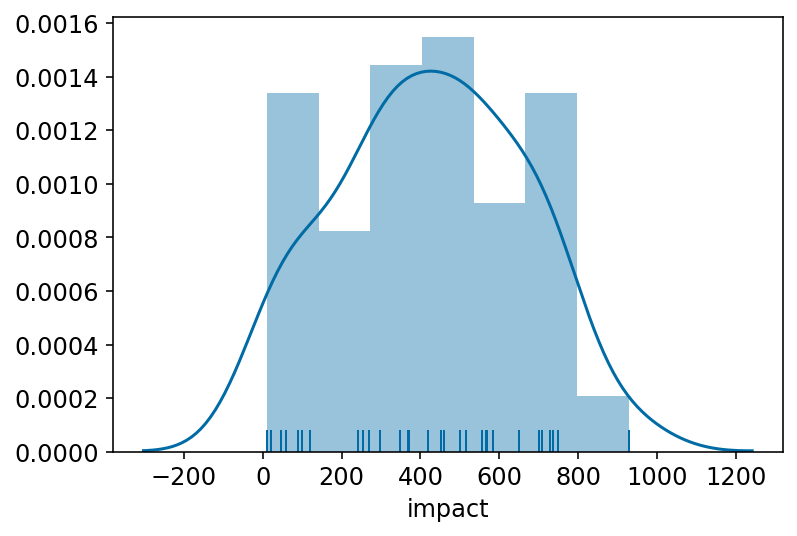

In [47]:
sns.distplot(df['impact'],rug=True)

In [48]:
df['impact'].describe()

count     74.000000
mean     423.468919
std      234.109585
min       11.000000
25%      253.000000
50%      419.000000
75%      568.200000
max      928.000000
Name: impact, dtype: float64

In [49]:
df_gpu['watt'].describe()

count     17.000000
mean     210.882353
std       74.775399
min       30.000000
25%      180.000000
50%      250.000000
75%      250.000000
max      300.000000
Name: watt, dtype: float64

In [50]:
df.loc[(df['provider'] == 'gcp') & (df['region'] == 'asia-east1')]['impact']

0    585.0
Name: impact, dtype: float64

In [51]:
def calculateCo2e( gpu, provider='gcp', region='asia-east1',hours=1):
    '''energy = time * watt
        CO2e = energy * impact
    '''
    energy = (hours * df_gpu.loc[df_gpu['name'] == gpu]['watt'].values[0]) /1000
    print('energy used : {} kWh'.format(energy))
    impact = df.loc[(df['provider'] == provider) & (df['region'] == region)]['impact'].values[0] / 1000
    print('co2 impact of {} {} : {} kg/kWh'.format(provider,region,impact))
    co2e = energy * impact
    print('CO2e : {} kg'.format(co2e))
    return co2e

In [52]:
calculateCo2e('GTX 1080 Ti','gcp','asia-east1',1.6679636111111111)

energy used : 0.4169909027777778 kWh
co2 impact of gcp asia-east1 : 0.585 kg/kWh
CO2e : 0.24393967812499998 kg


0.24393967812499998

In [53]:
def offset(gpu, provider='gcp', region='asia-east1',hours=1):
    offset_value = df.loc[(df['provider'] == provider) & (df['region'] == region)]['offsetRatio'].values[0]
    print('offset percent : {}%'.format(offset_value))
    offset = calculateCo2e(gpu, provider, region,hours) * offset_value / 100
    return offset

In [54]:
print('offset {}'.format(offset('GTX 1080 Ti','gcp','asia-east1',1.67)))

offset percent : 100%
energy used : 0.4175 kWh
co2 impact of gcp asia-east1 : 0.585 kg/kWh
CO2e : 0.24423749999999997 kg
offset 0.2442375


## Region-wise visualisation

In [55]:
df_plot = df.sort_values('impact')

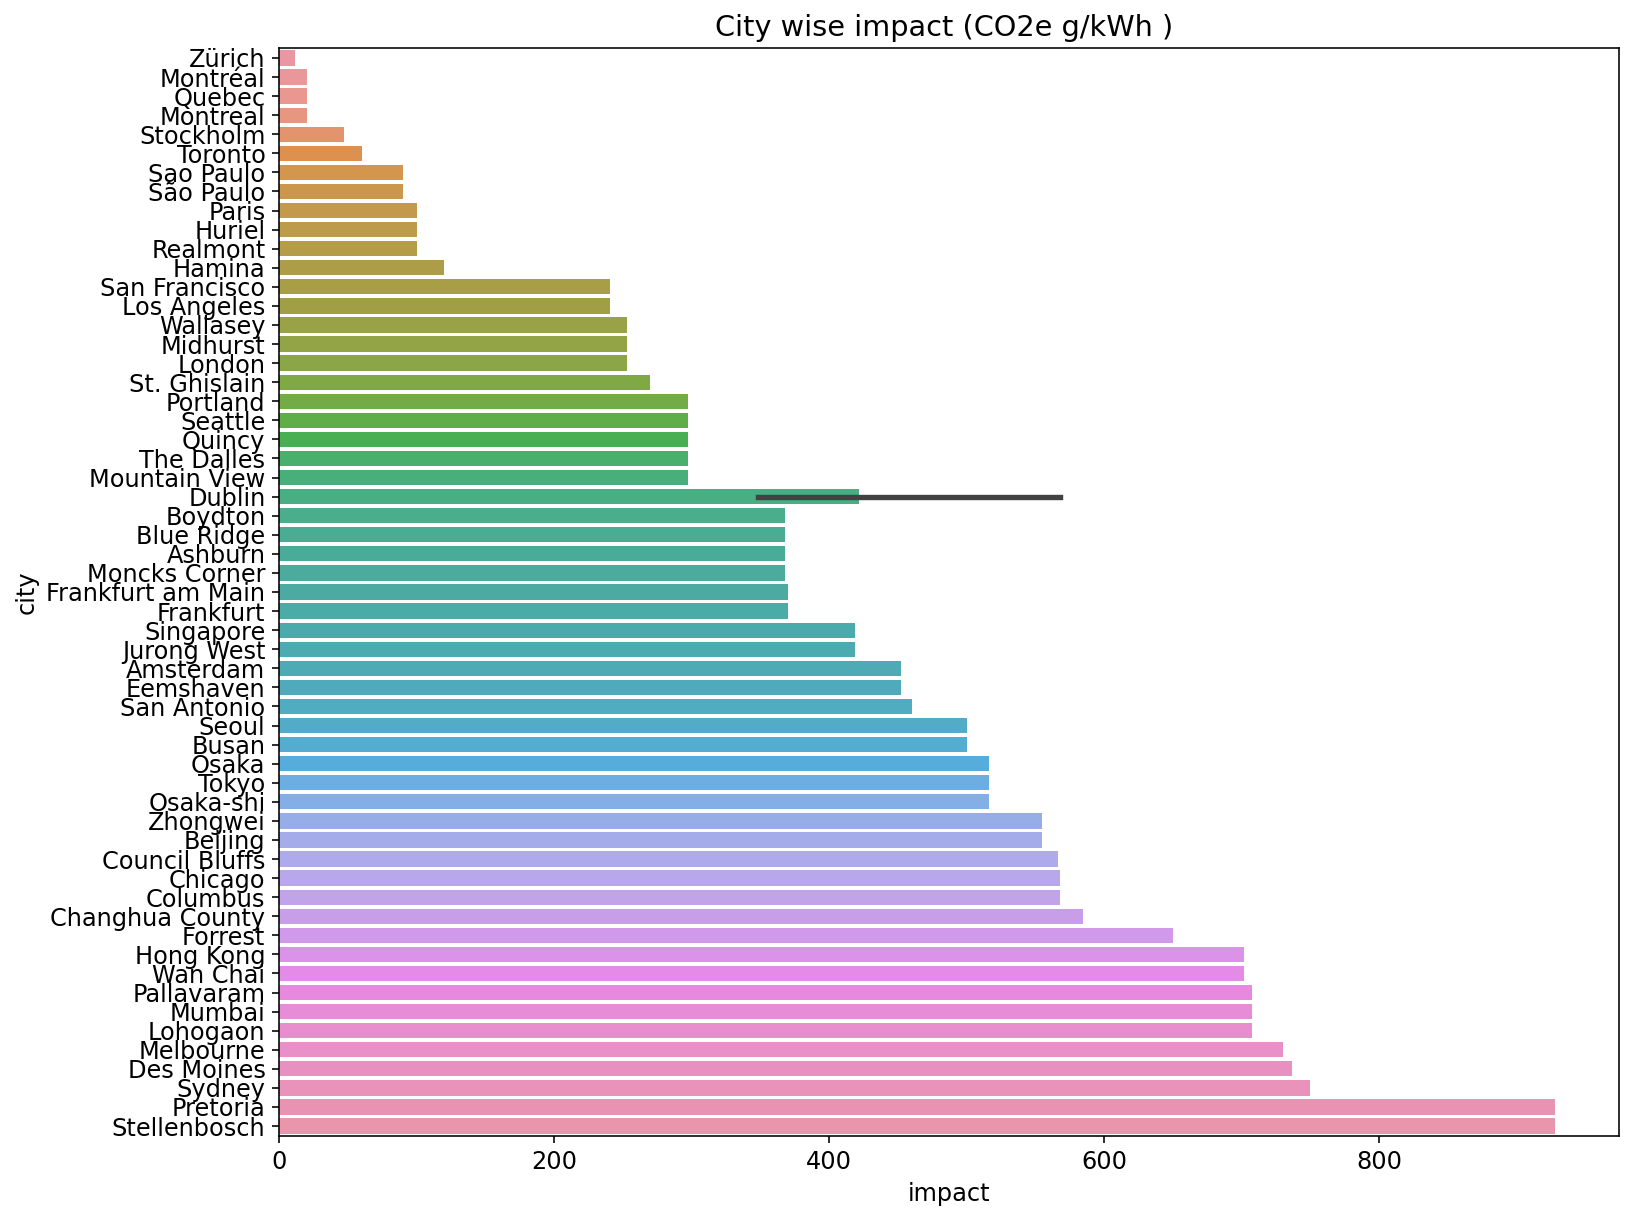

In [56]:
plt.figure(figsize=(12,10))
ax = sns.barplot(x='impact',y='city',data=df_plot)
ax.set_title("City wise impact (CO2e g/kWh ) ")
plt.show()

In [57]:
df_plot[df_plot['city'] == 'Mumbai']

,provider,providerName,offsetRatio,region,regionName,country,state,city,impact,source,comment
4,gcp,Google Cloud Platform,100,asia-south1,NaN,India,NaN,Mumbai,708.0,https://www.carbonfootprint.com/docs/2020_07_e...,Climate Transparency (2019 Report)
25,aws,Amazon Web Services,0,ap-south-1,Asia Pacific (Mumbai),India,NaN,Mumbai,708.0,https://www.carbonfootprint.com/docs/2020_07_e...,Climate Transparency (2019 Report)
59,azure,Azure,100,westindia,West India,India,Maharashtra,Mumbai,708.0,https://www.carbonfootprint.com/docs/2020_07_e...,Climate Transparency (2019 Report)


In [58]:
df_plot[df_plot['country'] == 'Switzerland']

,provider,providerName,offsetRatio,region,regionName,country,state,city,impact,source,comment
12,gcp,Google Cloud Platform,100,europe-west6,NaN,Switzerland,NaN,Zürich,11.0,https://www.carbonfootprint.com/docs/2020_07_e...,NaN


In [59]:
df_plot[df_plot['city'] == 'Pallavaram']

,provider,providerName,offsetRatio,region,regionName,country,state,city,impact,source,comment
57,azure,Azure,100,southindia,South India,India,Tamil Nadu,Pallavaram,708.0,https://www.carbonfootprint.com/docs/2020_07_e...,Climate Transparency (2019 Report)


some cities are repeated

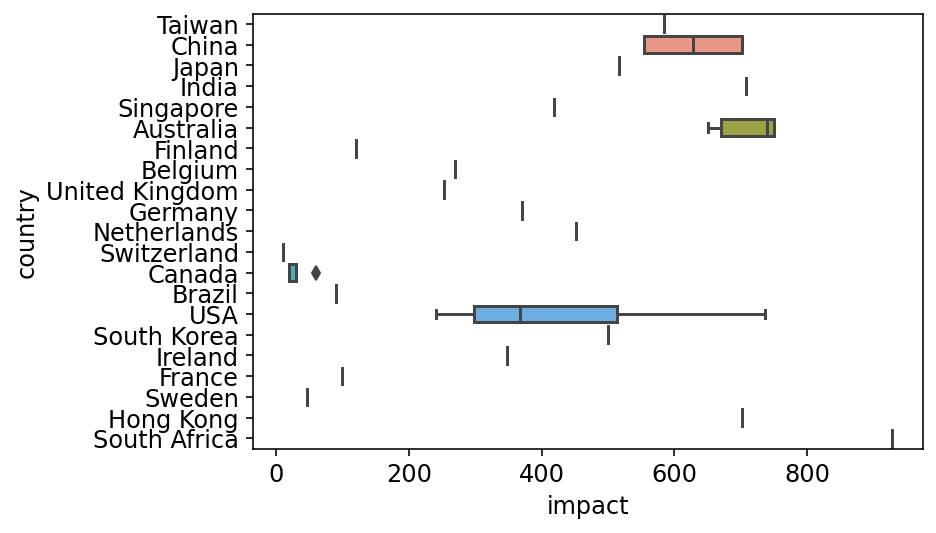

In [60]:
ax = sns.boxplot(x='impact', y='country', data=df)

/Users/shivangi/Documents/power_monitor/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


<StemContainer object of 3 artists>

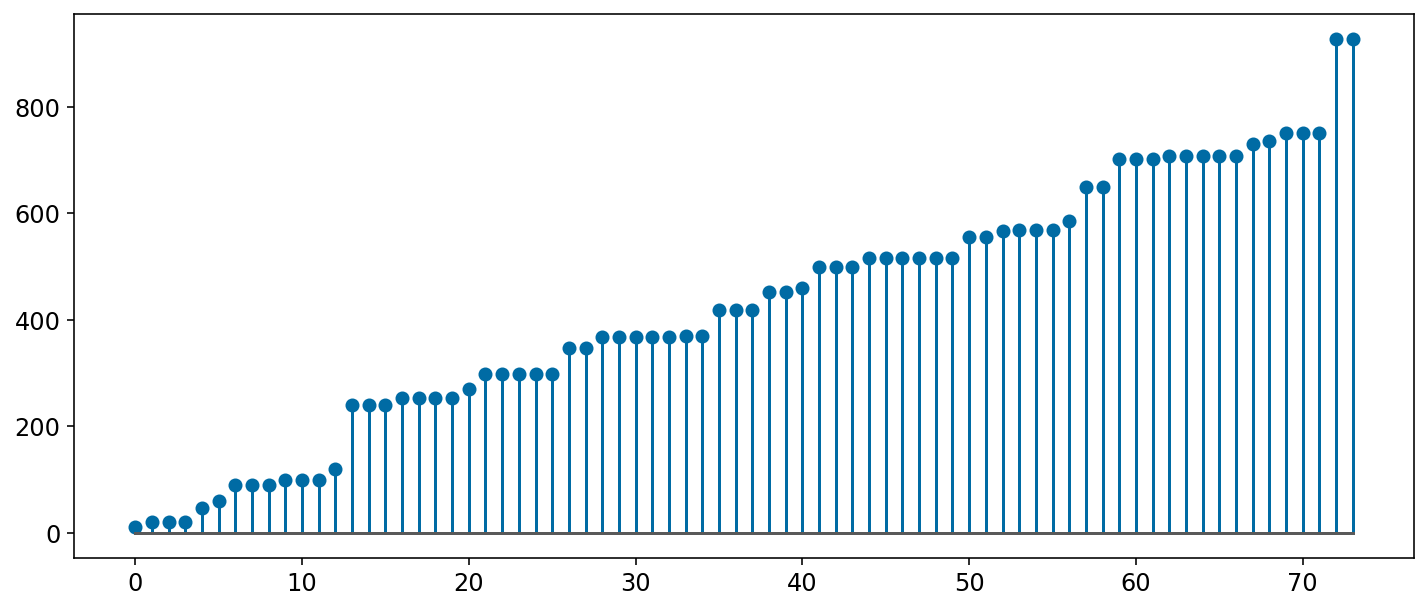

In [61]:
plt.figure(figsize=(12,5))
plt.stem(df_plot['impact'])

In [62]:
import pycountry_convert as pc

df['country_code'] = [pc.country_name_to_country_alpha2(country, cn_name_format="default") for country in df['country']]
df['continent'] = [pc.country_alpha2_to_continent_code(cc) for cc in df['country_code']]
df.continent.unique()

array(['AS', 'OC', 'EU', 'NA', 'SA', 'AF'], dtype=object)

In [63]:
continents_map = {
    'AS': 'Asia',
    'OC': 'Australia',
    'EU': 'Europe',
    'NA': 'North America',
    'SA': 'South America',
    'AF': 'Africa',
}

In [64]:
df['continent_name'] = [continents_map[c] for c in df.continent]

In [65]:
df.to_csv("../BERT/results/co2data.csv", index=False)

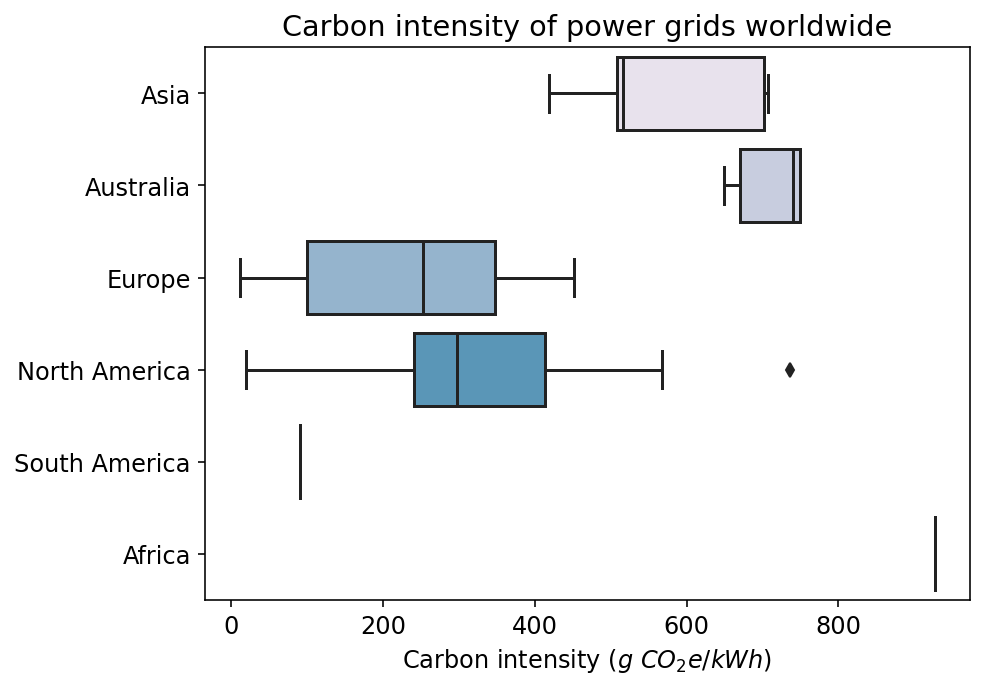

In [71]:
fig, ax = plt.subplots(figsize=(7,5))
ax = sns.boxplot(x='impact', y='continent_name',
                 data=df,palette='PuBuGn')
ax.set_xlabel("Carbon intensity ($g\ CO_2e/kWh$)")
ax.set_ylabel("")
ax.set_title("Carbon intensity of power grids worldwide")
plt.tight_layout()
ax.figure.savefig("viz/avgCO2Worldwide.png", dpi=300)

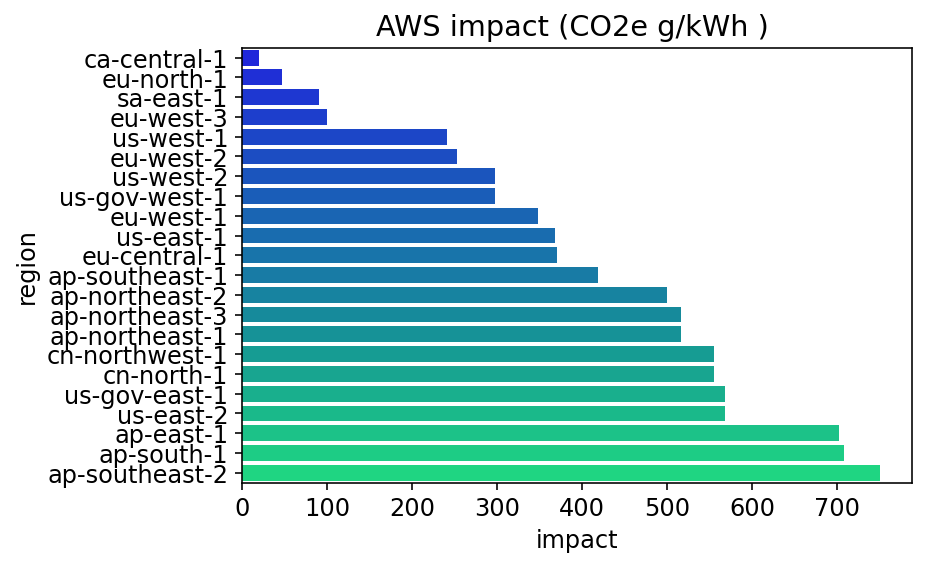

In [31]:
ax = sns.barplot(x='impact',y='region',
                 data=df_plot.loc[df_plot['provider'] == 'aws'], palette="winter")
ax.set_title("AWS impact (CO2e g/kWh ) ")
plt.show()

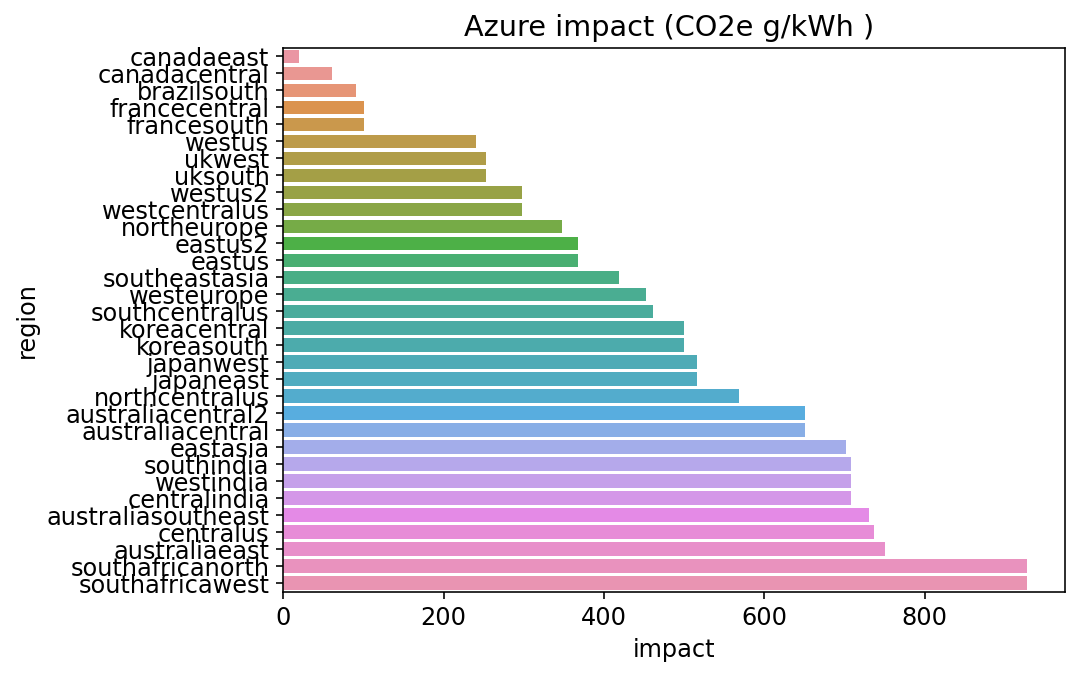

In [32]:
plt.figure(figsize=(7,5))
ax = sns.barplot(x='impact',y='region',data=df_plot.loc[df_plot['provider'] == 'azure'])
ax.set_title("Azure impact (CO2e g/kWh ) ")
plt.show()

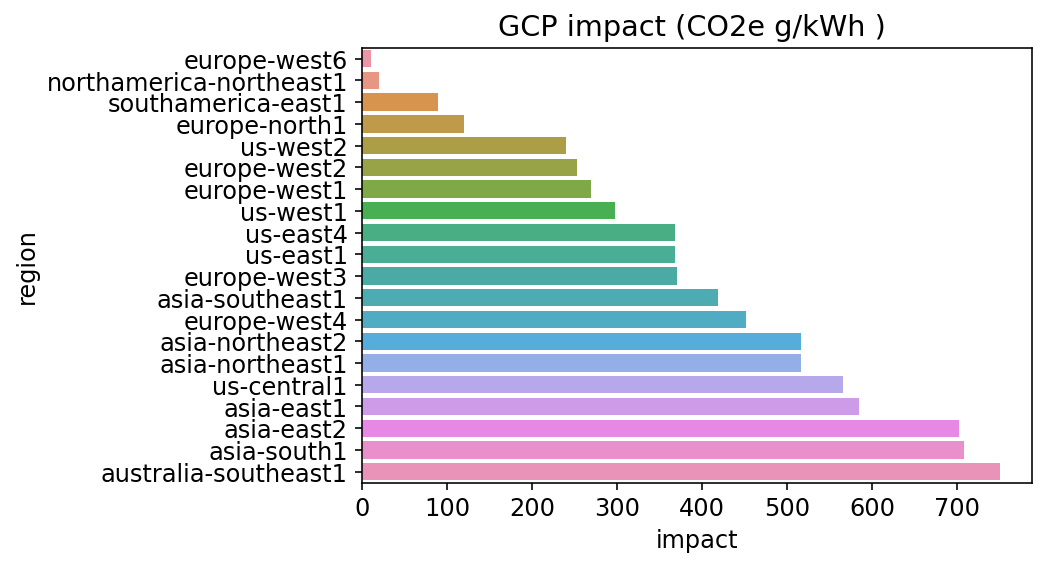

In [33]:
ax = sns.barplot(x='impact',y='region',data=df_plot.loc[df_plot['provider'] == 'gcp'])
ax.set_title("GCP impact (CO2e g/kWh ) ")
plt.show()

In [34]:
# ax = sns.barplot(x='impact',y='region',data=df_plot.loc[df_plot['provider'] == 'gcp'], )
ax.set_title("GCP impact (CO2e g/kWh ) ")
plt.show()

In [35]:
df = df_plot[['country','impact']].groupby('country').mean()
df.sort_values('impact', inplace=True)
df.reset_index(inplace=True)

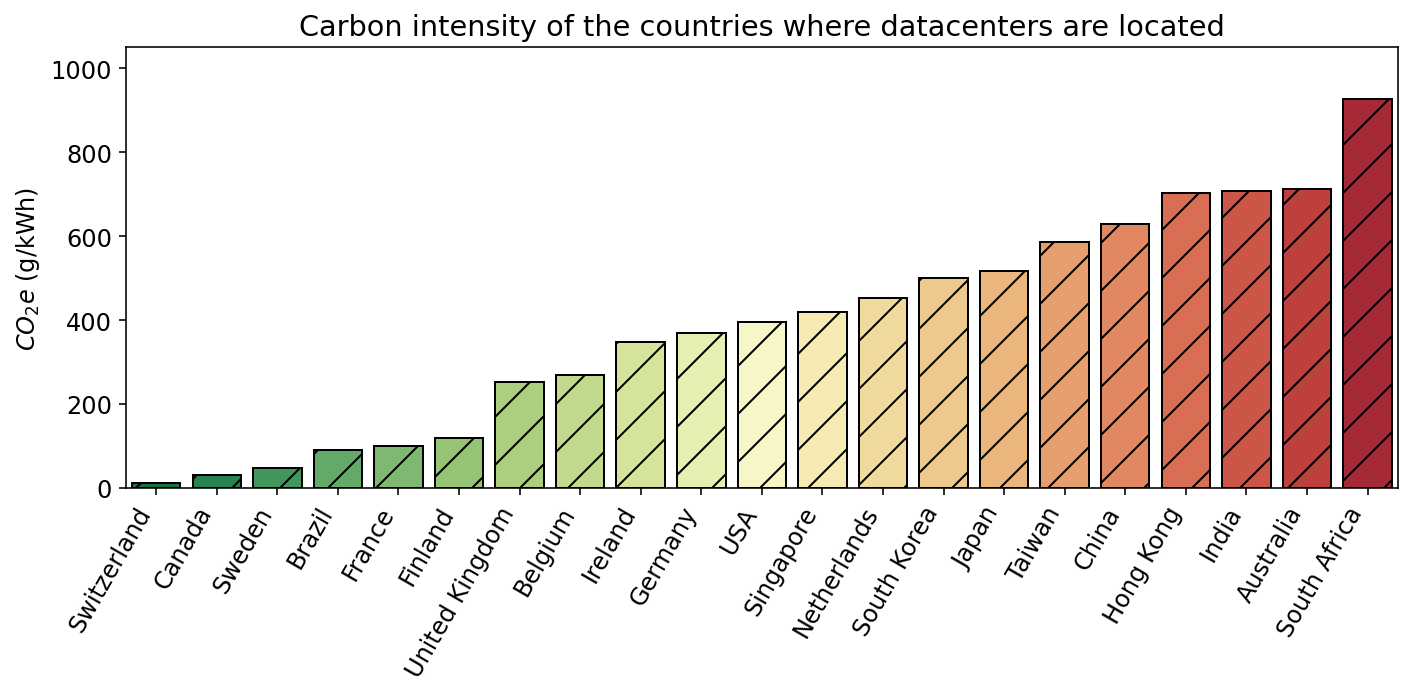

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
# ax.vlines(x=df.index, ymin=0, ymax=df.impact, color='firebrick', alpha=0.7, linewidth=2)
# ax.scatter(x=df.index, y=df.impact, s=75, color='firebrick', alpha=0.7)
ax = sns.barplot(x='country',y='impact',data=df,palette='RdYlGn_r',edgecolor='black')
bars = ax.patches
hatches = ''.join(h*len(df) for h in '/\.x')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    
ax.set_title('Carbon intensity of the countries where datacenters are located')
ax.set_ylabel('$CO_2e$ (g/kWh)')
ax.set_xlabel('')
ax.set_xticks(df.index)
ax.set_xticklabels(df.country, rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 1050)
plt.tight_layout()
plt.savefig('viz/countrywiseco2.png', dpi=300)

In [37]:
(df.loc[20].impact - df.loc[0].impact )/ df.loc[0].impact

83.36363636363636

## choropleth map

In [287]:
df.country.unique()

array(['Switzerland', 'Canada', 'Sweden', 'Brazil', 'France', 'Finland',
       'United Kingdom', 'Belgium', 'Ireland', 'Germany', 'USA',
       'Singapore', 'Netherlands', 'South Korea', 'Japan', 'Taiwan',
       'China', 'Hong Kong', 'India', 'Australia', 'South Africa'],
      dtype=object)

In [288]:
df.head()

,country,impact
0,Switzerland,11.0
1,Canada,30.0
2,Sweden,47.0
3,Brazil,90.0
4,France,100.0


In [289]:
df['country'].replace("USA","United States of America", inplace=True)

In [290]:
!pip install geopandas

You should consider upgrading via the 'pip install --upgrade pip' command.


In [291]:
import geopandas

In [292]:
geopandas.__version__

'0.8.1'

In [293]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [294]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [295]:
#world.plot()

In [296]:
world.count()

pop_est       177
continent     177
name          177
iso_a3        177
gdp_md_est    177
geometry      177
dtype: int64

In [297]:
merge = world.merge(df,how='outer',left_on="name", right_on="country")

In [298]:
merge.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,country,impact
0,920938.0,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN
1,53950935.0,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN,NaN
2,603253.0,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN
3,35623680.0,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,30.000000
4,326625791.0,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States of America,395.615789


In [299]:
#merge['impact'] = merge['impact'].fillna(0)

In [300]:
!pip install descartes

You should consider upgrading via the 'pip install --upgrade pip' command.


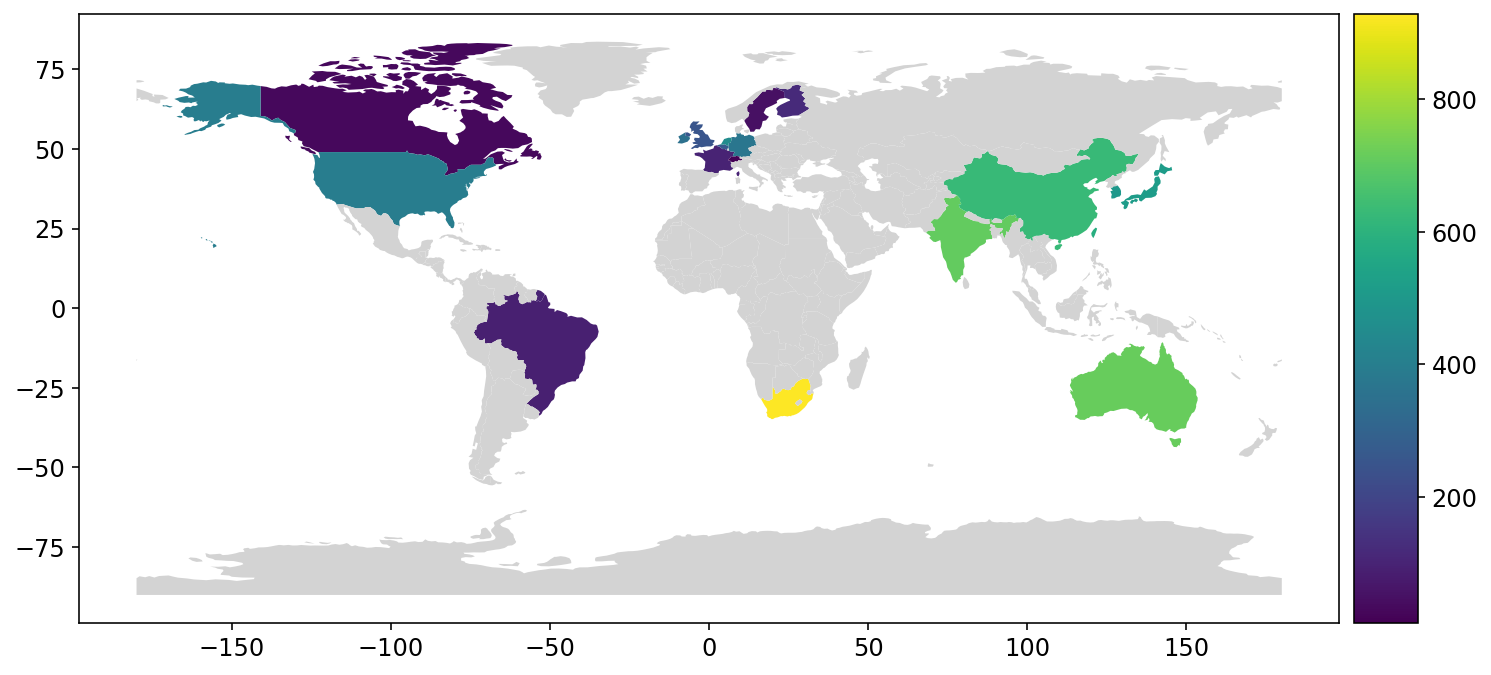

In [301]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
merge.plot(column='impact',ax=ax, legend=True, cax=cax, missing_kwds={ 'color':'lightgrey'})

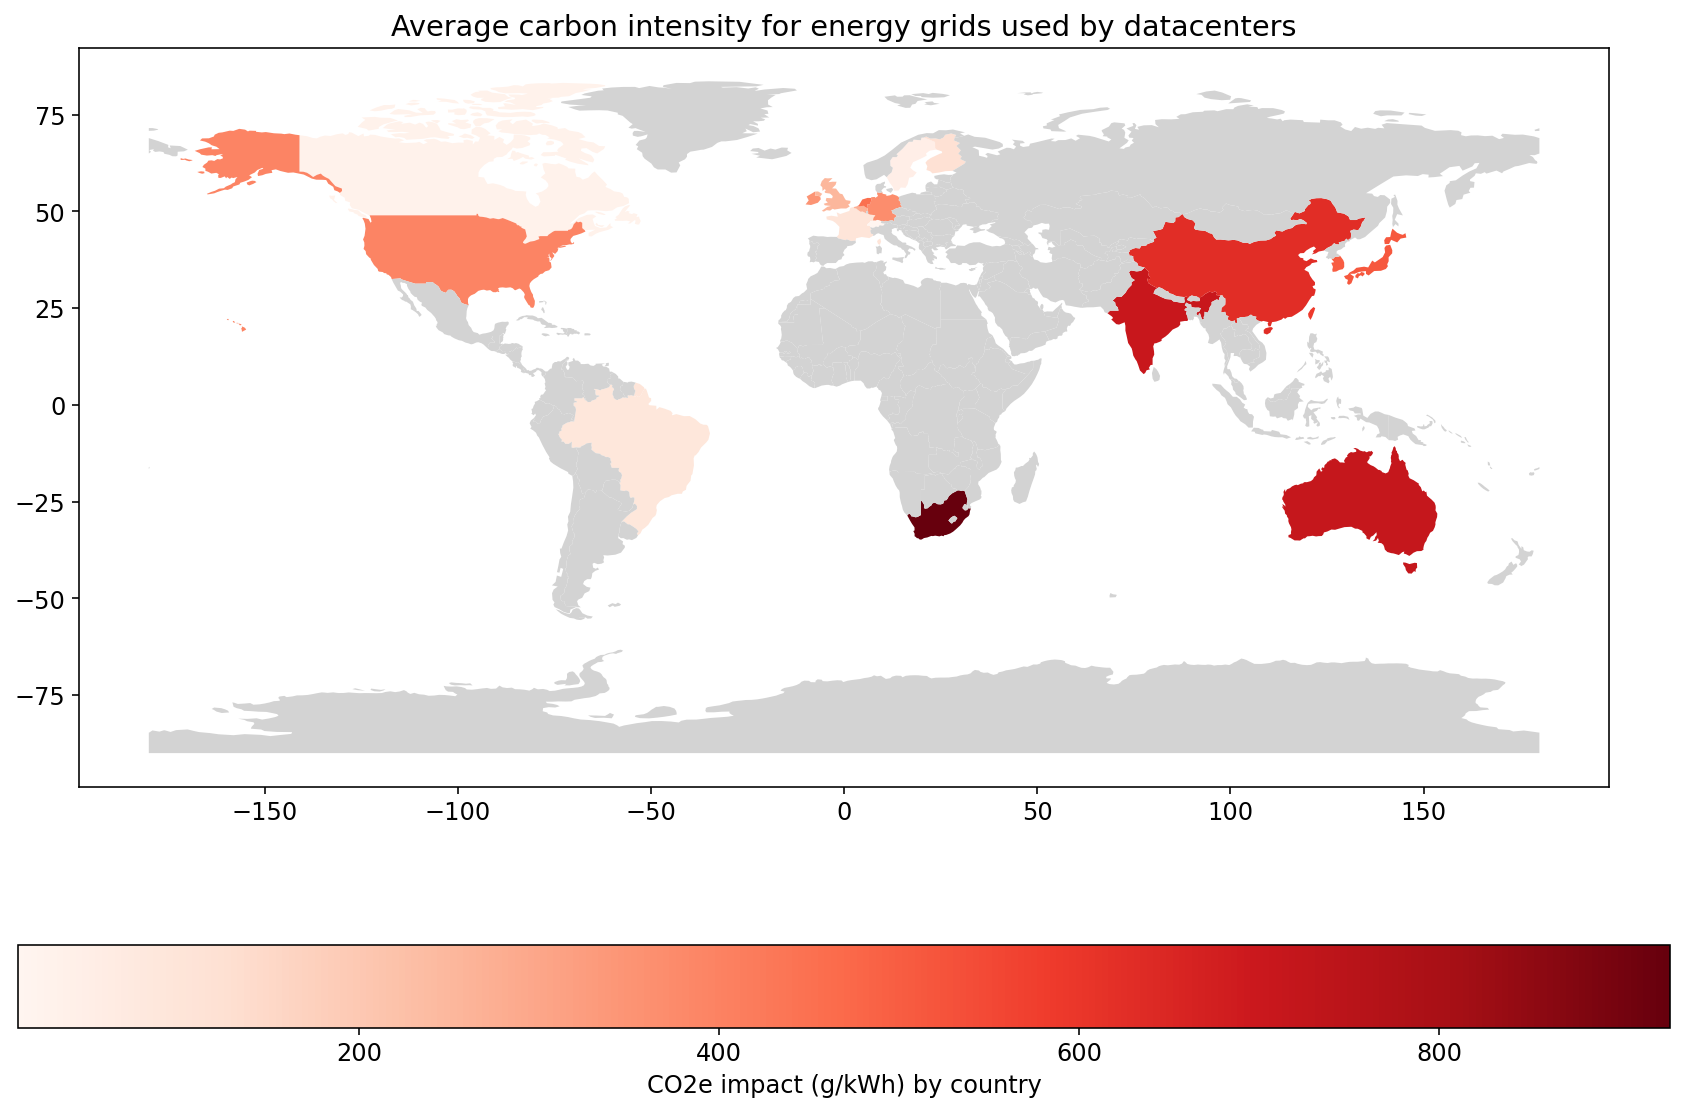

In [302]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

merge.plot(column='impact',ax=ax, legend=True,
           cmap='Reds',
           legend_kwds={'label': "CO2e impact (g/kWh) by country",
                     'orientation': "horizontal"},
          missing_kwds={'color': 'lightgrey'})
ax.set_title("Average carbon intensity for energy grids used by datacenters")
plt.tight_layout()
ax.figure.savefig("viz/choropleth.png",dpi=300)

### This map is wrong. Part of India is shown as Pakistan and China.